Structure:
  - We will take a look at the algorithm circuit in general.
  - Define some graphs to work with.
  - Define the necessary functions for the algorithm.
  - Try to run the algorithm with different approaches for optimization.
  ---

### QAOA:
[Original paper](https://arxiv.org/pdf/1411.4028.pdf)

Let's take a look at how the circuit would look like:
![QAOA circuit](https://drive.google.com/uc?id=1GExQVTasnTP8XAeNinDRQ9fCUT07vpo8)

Note that this is just a general example. \
Here each qubit represents a node in a graph. \
First of all, we are preparing a circuit by getting superposition of all qubits. \
Then applying the Ising ZZ gate with angle $\gamma$ for each pair of $i$ $j$ which represents an edge. \
In the end - applying Rx rotation gate with angle $\beta$ to all the qubits. \
We are repeating that $p$ times and at the very end measuring the result. \

 Having perfect angles would give us a bitstring where 1 and 0 are representing different partitions for the graph. We are expecting the approximation ratio to be at least 0.6924. which means we are likely will get a cut which is at least 0.69 times the best possible cut. \
To get the best angles we are going to use classical methods, trying to minimize or maximize the objective function. \


Note that with growing $p$ the depth of the circuit will grow by a number of edges multiplyed on p + p. \
$p$ basically describes how many angles sets we are going to use. Using more angles gives us better results. \

---


In [ ]:
#instaling the library
!git clone https://github.com/katolikyan/QCSimulator.git
!pip3 install QCSimulator/

In [ ]:
import qcsimulator as qcs
import tensornetwork as tn
import numpy as np
import networkx as nx
import scipy.optimize
import matplotlib.pyplot as plt

### Creating some graphs.
Let's define a couple of specific graphs that we will use later. \
We are going to use networkx lib for that.

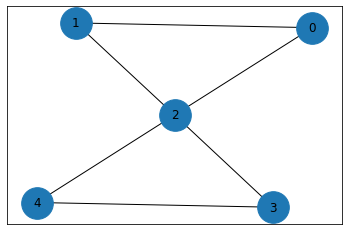

In [ ]:
n = 5 # number of nodes
V = np.arange(0, n) # list of nodes
E = [(0, 1), (0, 2), (1, 2), (3, 2), (3, 4), (4, 2)] # manually connecting edges
graph_btrfly = nx.Graph() # graph init
graph_btrfly.add_nodes_from(V)
graph_btrfly.add_edges_from(E)
nx.draw_networkx(graph_btrfly, node_size=1000)

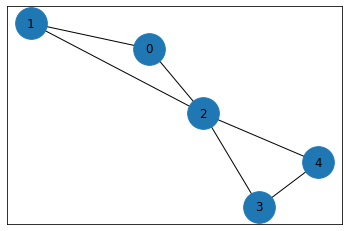

In [ ]:
# In this graph we also initializing weights for edges
n = 5
V = np.arange(0, n)
E = [(0, 1, 0.5), (0, 2, 0.9), (1, 2, 0.2), (3, 2, 0.4), (3, 4, 1.0), (4, 2, 0.7)]
graph_btrfly_w = nx.Graph()
graph_btrfly_w.add_nodes_from(V)
graph_btrfly_w.add_weighted_edges_from(E)
nx.draw_networkx(graph_btrfly_w, node_size=1000)

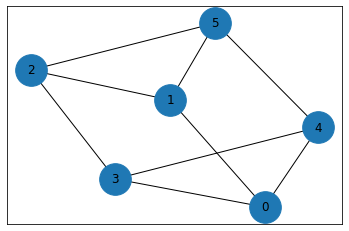

In [ ]:
# Just a 3 regular graph. which means each node has 3 edges
n = 6
V = np.arange(0, n)
E = [(0, 1), (0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (2, 5), (3, 4), (4, 5)]
graph_3reg_6n = nx.Graph()
graph_3reg_6n.add_nodes_from(V)
graph_3reg_6n.add_edges_from(E)
nx.draw_networkx(graph_3reg_6n, node_size=1000)

---
### Defining functions. 
In the cost function we are counting the number of 'disagreements'. If the node $i$ and $j$ are in different partitions we are incrementing cost by 1. \
This function is going to be the cost of a single bitstring. \
The mean of the sum of all costs for all bitstrings will be our objective function result which we will try to minimize.

Theoretically we also could use get_cut_size for that because it is should be kind of the same thing.

In [ ]:
def cost_function(bitstr, graph):
  cost = 0
  # flipping bitstring because it is in little-end
  bitstr = [int(i) for i in bitstr[::-1]] 
  # checking if the graph has weighted edges.
  weighted = nx.is_weighted(graph)        
  # checking each edge.
  for i, j in graph.edges:
    w = graph[i][j]['weight'] if weighted else 1
    cost += w * bitstr[i] * (1 - bitstr[j]) + w * bitstr[j] * (1 - bitstr[i])
  return cost

# NetworkX function that calculates cut size.
def get_cut_size(bitstr, graph):
  T = []
  S = []
  # Defining sets S and T according to bitstring. 
  # Bitstring is in little-end so we are flipping it to get right node indices
  for i, val in enumerate(bitstr[::-1]):
    if val == '1':
      T.append(int(i))
    else:
      S.append(int(i))
  return nx.cut_size(graph, S, T)

### Build circuit function.
Let's define a function that builds a circuit according to provided angles and a graph. \
The number of angles depends on $p$ and initialized outside of the function.


In [ ]:
def build_cirquit(angles, graph, p):
  # getting the number of qubits needed and the p
  n = len(graph.nodes)
  # separating beta and gamma angles
  betas = angles[:p]   
  gammas = angles[p:]
  cirquit = qcs.circuit_init(n)
  
  # Preparing all the qubits by applying H gate on them
  for i in range(n):
    cirquit.h(i)
  # For p times applying Ising ZZ gates to edges and Rx at the end.
  for beta, gamma in zip(betas, gammas):
    # Loop represents applying decomposed U(C, gamma)
    for i, j in graph.edges:
      cirquit.cx(i, j)
      cirquit.rz(j, gamma)
      cirquit.cx(i, j)
    # Loop represents applying U(B, beta)
    for i in range(n):
      cirquit.rx(i, beta)
    
  return cirquit

### Objective function.
In the objective function we are:
- building the circuit with angles and measuring it.
- calculating the cost of all the bitstring.
- returning the mean of costs. \

we are trying to reach the biggest mean cost value for the number of measured bitstrings. But because we are trying to minimize the function (using skipy) we are returning negative mean trying to find angles that give the lowest result. \

Instead of getting some N number of bitstrings we could just evaluate wavefunction. Take a look at all probabilities and calculate the result. \
But in real QC we would measure multiple times to get some distribution.

In [ ]:
def objective(angles, graph, p):
  # building and executing the circuit
  cirquit = build_cirquit(angles, graph, p)
  result = cirquit.execute()
  # getting randomly guessed bitstrings according to probabilities. Measurement equivalent.
  bitstrings = result.measure_all(shots=256)

  costs = []
  # calculating cost for each bitstring we've got
  for bitstr in bitstrings:
    costs.append(cost_function(bitstr, graph))

  # returning negative average because we need to minimize the function.
  return -np.mean(costs) 

---
### Guessing the best angles.
For now, let's consider $p = 1$, So we have only 2 parameters: $\gamma, \beta$. \
Let's take a look at how objective function looks like for a specific graph. \
To find the best angles we will simply search in some possible combinations of $\gamma$ and $\beta$ and take a look at which angels give us the minimum for the function. 
So the minimum we are printing represents the mean cut with the opposite sign we are getting from the objective function.

The minimum found : -3.8203125
The angles ______ : (5.385587406153931, 0.4487989505128276)


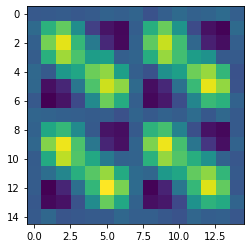

In [ ]:
# choosing a graph: graph_btrfly, graph_btrfly_w, graph_3reg_6n
graph = graph_btrfly
p = 1 

# defining the step size to iterate between 0 and 2pi
step = 15
values = []
angles = []
# iterating thgrough all the combinations.
for gamma in np.linspace(0, 2 * np.pi, step):
  for beta in np.linspace(0, 2 * np.pi, step):
    # Getting a result from objective function with given angles.
    cost = objective([gamma, beta], graph, p)
    values.append(cost)
    angles.append((gamma, beta))
  
# getting the best minimum value index
idx = np.argmin(values)

# printing the grid and best angles.
plt.imshow(np.array(values).reshape(step, step))
print("The minimum found :", values[idx])
print("The angles ______ :", angles[idx])

Measured bitstring :  00100
cut size _________ :  4
Measured bitstring :  01100
cut size _________ :  4
Measured bitstring :  01011
cut size _________ :  4
------
Distribution of cuts:  {0: 157, 1: 0, 2: 845, 3: 0, 4: 8998, 5: 0} 

Cuts probabilities : {0: 0.015310156245308158, 1: 0, 2: 0.08452736559412888, 3: 0, 4: 0.9001624781605622, 5: 0}


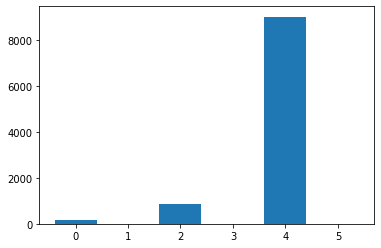

In [ ]:
# Let's build a circuit with those angles and pick some random bitstrings. 
guess_cirquit = build_cirquit(angles[idx], graph, p)
result = guess_cirquit.execute()
# lets measure 3 times:
bitstrings = result.measure_all(shots=3)
for bitstr in bitstrings:
  print("Measured bitstring : ", bitstr)
  print("cut size _________ : ", get_cut_size(bitstr, graph))
print("------")

# -----
# We can take a look to cuts distribution if we measure let's say a 10k times
bitstrings = result.measure_all(shots=10000)

cuts = {}
for i, enge in enumerate(graph.edges):
  cuts[i] = 0
for bitstr in bitstrings:
  cuts[get_cut_size(bitstr, graph)] += 1

print("Distribution of cuts: ", cuts, "\n")
plt.bar(cuts.keys(), cuts.values())

# Of course, we could just look at all bitstring probabilities and calculate
# probabilities for getting a specific cut:
cut_probs = {}
for i, enge in enumerate(graph.edges):
  cut_probs[i] = 0
probs = result.get_all_probabilities()
for bitstr, prob in probs.items():
  cut_probs[get_cut_size(bitstr, graph)] += prob

print("Cuts probabilities :", cut_probs)

---
### 3 regular graph.
let's build graphs which would represent all possible subgraphs of 3 regular connected graph with distance $p = 1$

In [ ]:
# g4 subgraph
n = 4 # number of nodes
V = np.arange(0, n)  # list of nodes
E = [(0, 1), (0, 3), (0, 2), (1, 2), (2, 3)] # manually connecting edges
g4 = nx.Graph() # graph init
g4.add_nodes_from(V) 
g4.add_edges_from(E)

# g5 subgraph
n = 5 # number of nodes
V = np.arange(0, n)  # list of nodes
E = [(0, 1), (1, 2), (1, 3), (2, 3), (3, 4)] # manually connecting edges
g5 = nx.Graph() # graph init
g5.add_nodes_from(V) 
g5.add_edges_from(E)

# g6 subgraph
n = 6 # number of nodes
V = np.arange(0, n)  # list of nodes
E = [(0, 1), (1, 2), (1, 3), (3, 4), (3, 5)] # manually connecting edges
g6 = nx.Graph() # graph init
g6.add_nodes_from(V) 
g6.add_edges_from(E)

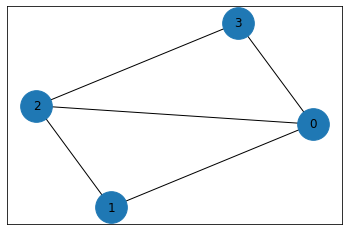

In [ ]:
nx.draw_networkx(g4, node_size=1000)

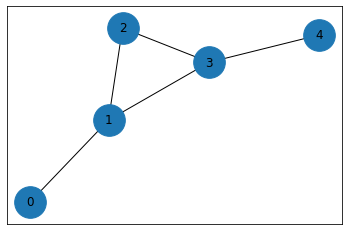

In [ ]:
nx.draw_networkx(g5, node_size=1000)

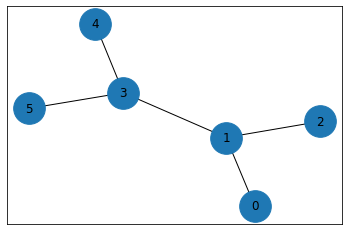

In [ ]:
nx.draw_networkx(g6, node_size=1000)

According to the paper, the resulting objective function of the graph is a linear combination of all subgraphs described by the distance p. \

$F1 (γ , β ) = Sfg4(γ , β) + (4S + 3T)fg5(γ , β) + (3n − 5S − 3T)fg6(γ , β )$ \

Where $S$ is a number of isolated squares, $T$ - number of isolated triangles, n - number of nodes. \
Isolated $S$ and $T$ look like: \
![Isolated_S_T](https://drive.google.com/uc?id=18MAbHvtaSe77g4oKDKap5zkPcGGwe-p-)
To calculate the T and S we have the folowing function:

In [ ]:
def get_reg3_graph_t_s(graph):
  T = 0
  S = 0
  # looping through all the edges.
  for node_1, node_2 in graph.edges:
    unique_nodes = 0
    neighb_1 = [n for n in graph.neighbors(node_1)]  # all neighbors of node_1
    for node in graph.neighbors(node_2):
      if node not in neighb_1 and node != node_1: # looking for unique node
        unique_nodes += 1
  
    if unique_nodes == 0:
      S += 1
    if unique_nodes == 1:
      T += 1
  
  # We are increasing T for each edge with 1 unique neighbor. 
  # That's why we have to divide by 3. 
  # For each S found we are also increasing T by 4.
  # That's why we have to subtract S * 4 from total T. 
  T = int((T - S * 4) / 3)
  return {'T': T, 'S': S}

### Special objective.
The following function will be our new objective for a special case. \
This function potentially can be modified to accept any graph with specific subgraphs, \
but to keep things simple we will hardcode it for 3 regular graph with p = 1. 

In [ ]:
def reg3graph_objective(angles, subgraphs, n, S, T, p):
  # calculating cost for each subgraph.
  f_g4 = objective(angles, subgraphs[0], p)
  f_g5 = objective(angles, subgraphs[1], p)
  f_g6 = objective(angles, subgraphs[2], p)
  # summing according the formula.
  f = S * f_g4 + (4 * S + 3 * T) * f_g5 + (3 * n / 2 - 5 * S - 3 * T) * f_g6
  return f

If we look at our 3 regular graph above we can just easily see the number of $T$ and $S$ in it. \
There are 2 isolated triangles and 0 isolated squares.

T and S in the graph: {'T': 2, 'S': 0}

Measured bitstring :  010110
cut size _________ :  7
Measured bitstring :  101011
cut size _________ :  6
Measured bitstring :  010101
cut size _________ :  7
------
Distribution of cuts:  {0: 19, 1: 0, 2: 0, 3: 359, 4: 546, 5: 2895, 6: 2305, 7: 3876, 8: 0} 



<BarContainer object of 9 artists>

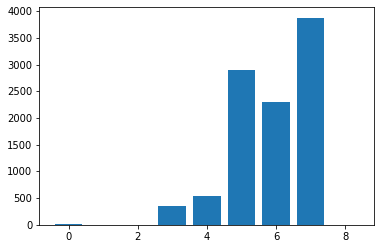

In [ ]:
# Let's build algorithm on 3 regular graph we have created above. There is:
graph = graph_3reg_6n
# let's just validate we have correct T S
ts = get_reg3_graph_t_s(graph)
print("T and S in the graph: {}\n".format(ts))

p = 1
S = ts['S']
T = ts['T']
n = len(graph.nodes) # number of nodes.

# Defigning angles
# size is p * 2 because for optimization we are going to pass betas and gammas
# as a list of parameters.
angles = np.random.uniform(0, 2 * np.pi, size=(p * 2))
# subgraphs for 3 regular connected graph where p = 1
subgraphs = [g4, g5, g6]

optimization_result = scipy.optimize.minimize(\
  reg3graph_objective, angles, args=(subgraphs, n, S, T, p), method='Powell')
# Getting the best angles:
optimized_angles = optimization_result.x

# -----
# building a circuit with those angles. 
guess_cirquit = build_cirquit(optimized_angles, graph, p)
result = guess_cirquit.execute()
# lets measure 3 times:
bitstrings = result.measure_all(shots=3)
for bitstr in bitstrings:
  print("Measured bitstring : ", bitstr)
  print("cut size _________ : ", get_cut_size(bitstr, graph))
print("------")

# -----
# Cuts distribution:
bitstrings = result.measure_all(shots=10000)
cuts = {}
for i, enge in enumerate(graph.edges):
  cuts[i] = 0
for bitstr in bitstrings:
  cuts[get_cut_size(bitstr, graph)] += 1

print("Distribution of cuts: ", cuts, "\n")
plt.bar(cuts.keys(), cuts.values())

---
### $p > 1$
Let's now try to get some results with $p > 1$. We can set $p$ and $graph$ variables to what we want and run the cell. Notice that $p >= 3$ takes time to calculate.

Measured bitstring :  100101
cut size _________ :  7
Measured bitstring :  000101
cut size _________ :  6
Measured bitstring :  010110
cut size _________ :  7
------
Distribution of cuts:  {0: 23, 1: 0, 2: 0, 3: 66, 4: 286, 5: 738, 6: 1898, 7: 6989, 8: 0} 



<BarContainer object of 9 artists>

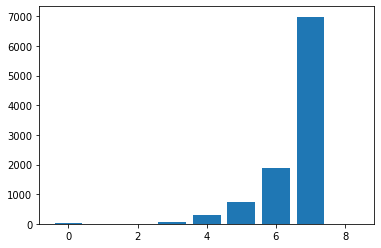

In [ ]:
# choosing our p and graph:
p = 3
graph = graph_3reg_6n # graph_btrfly, graph_btrfly_w or graph_3reg_6n or random
angles = np.random.uniform(0, 2 * np.pi, size=(p * 2)) # random initial angels:

# Trying to optimize the angles:
optimization_result = scipy.optimize.minimize(\
                      objective, angles, args=(graph, p), method='Powell')
# Getting the best angles:
optimized_angles = optimization_result.x

# Building a circuit with those angles. 
guess_cirquit = build_cirquit(optimized_angles, graph, p)
result = guess_cirquit.execute()

# Measuring 3 random bitstrings:
bitstrings = result.measure_all(shots=3)
for bitstr in bitstrings:
  print("Measured bitstring : ", bitstr)
  print("cut size _________ : ", get_cut_size(bitstr, graph))
print("------")

# -----
# Cuts distribution:
bitstrings = result.measure_all(shots=10000)

cuts = {}
for i, enge in enumerate(graph.edges):
  cuts[i] = 0
for bitstr in bitstrings:
  cuts[get_cut_size(bitstr, graph)] += 1

print("Distribution of cuts: ", cuts, "\n")

plt.bar(cuts.keys(), cuts.values())

--- 
#### Thank you!
All info and updates for the lib can be found on the project's repo on GitHub: \
https://github.com/katolikyan/QCSimulator \
Do not hesitate to open an issue and contribute :)